### Import des modules

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import des données

In [152]:
data=pd.read_csv("/Users/mafaldafrere/Documents/Cours/IODAA/PROG/PROJET/classif_thyroid_disease/thyroidDF.csv")
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


Premières observations : 
- Des variables vont produire du data leakage (prise de traitement => malade) 
- Variables inutiles telles que "T4U_measured" => indique si NA ou pas dans la colonne "T4U"
- Beaucoup de NA sur certaines colonnes => comment gérer ? 
- Prédiction multi-classes (20 classes): réduire le nombre de classes
- Gestion de classes désiquilibrées

### 1. Exploration Préliminaire
#### A. Colonnes diverses de X
Dans le dataset il y a des mesures de taux d'hormones, et à chaque colonne numérique de mesure est associée une colonne indiquant si oui ou non la mesure a été réalisée. Ces colonnes n'apportent aucune information supplémentaire (car se traduisent par un Na dans la colonne numérique de mesure). Je décide donc de les retirer.

In [153]:
data.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured','FTI_measured', 'TBG_measured'], axis=1, inplace=True)

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

In [155]:
# Premières observations des variables numériques
data.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG,patient_id
count,9172.000000,8330.000000,6568.000000,8730.000000,8363.000000,8370.000000,349.000000,9.172000e+03
mean,73.555822,5.218403,1.970629,108.700305,0.976056,113.640746,29.870057,8.529473e+08
std,1183.976718,24.184006,0.887579,37.522670,0.200360,41.551650,21.080504,7.581969e+06
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000,0.100000,8.408010e+08
25%,37.000000,0.460000,1.500000,87.000000,0.860000,93.000000,21.000000,8.504090e+08
50%,55.000000,1.400000,1.900000,104.000000,0.960000,109.000000,26.000000,8.510040e+08
75%,68.000000,2.700000,2.300000,126.000000,1.065000,128.000000,31.000000,8.607110e+08
max,65526.000000,530.000000,18.000000,600.000000,2.330000,881.000000,200.000000,8.701190e+08


**Observations :**
- L'âge max est à 65526 ???

In [156]:
data[data.age > 100]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,TSH,T3,TT4,T4U,FTI,TBG,referral_source,target,patient_id
2976,455,F,f,f,f,f,f,f,f,f,...,f,1.10,2.0,118.0,1.13,104.0,NaN,SVI,-,850530001
5710,65511,M,f,f,f,f,f,f,f,f,...,f,0.38,2.0,113.0,1.08,104.0,NaN,other,-,860210008
6392,65512,M,f,f,f,f,f,f,f,f,...,f,0.03,2.8,112.0,0.84,133.0,NaN,other,-,860403050
8105,65526,F,f,f,f,f,f,f,f,f,...,f,1.50,NaN,132.0,1.02,129.0,NaN,other,-,861014041


Je décide de retirer tous les individus d'âge supérieur à 100. De toute façon, ces individus sont sains (et il s'agit de la classe majoritaire). 

In [157]:
data['age'] = np.where((data.age > 100), np.nan, data.age)

Je regarde si il y a des duplicats de lignes, et de patient_ID. 

In [158]:
print(data.duplicated().any())
print(data.duplicated(subset=['patient_id']).any())

False
False


Il n'y a aucun duplicat donc je retire patient_id puisqu'il n'apporte aucune information. Je décide également de retirer la colonne "referral_source", qui indique par quel moyen le patient a effectué les tests pour les maladies de la thyroïde. Cette colonne pourrait apporter un biais (certaines sources peuvent amener plus de malades), et elle n'apporte pas beaucoup d'information de toute façon.  

In [159]:
data.drop(['patient_id', 'referral_source'], axis=1, inplace=True)

Enfin, plusieurs colonnes sont liées à un traitement médical post-diagnostic ('on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_meds' 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid'). Dans le cadre d'un modèle de diagnostic, ce n'est pas très réaliste de les inclure. On va cependant les garder pour le moment et voir avec un premier modèle baseline si effectivement l'accuracy chute lorsqu'on les retire (ce qui indiquerait qu'on a affaire à du data leakage).

#### B. Colonne Target
La colonne "target" fait référence au diagnostic (c'est notre variable cible). C'est une colonne avec beaucoup de classes, et un formalisme particulier. Le diagnostic consiste en une chaîne de caractères, chaque caractère faisant référence à une pathologie. On peut aussi avoir des structures de type "X|Y", où le diagnostic est cohérent pour la pathologie X mais où le patient est plus probablement atteint de la pathologie Y. Egalement, si le patient est atteint de plusieurs pathologies comme X et Y, le diagnostic s'écrit "XY". De plus, les pathologies sont regroupées en méta-catégories dans la documentation Kaggle associée au dataset. 
Il y a donc quelques modifications possibles sur cette colonne. (Voir la documentation Kaggle sur ce dataset pour avoir les correspondance lettre - pathologie).

In [160]:
data['target'].value_counts()

target
-      6771
K       436
G       359
I       346
F       233
R       196
A       147
L       115
M       111
N       110
S        85
GK       49
AK       46
J        30
B        21
MK       16
O        14
Q        14
C|I      12
KJ       11
GI       10
H|K       8
D         8
FK        6
C         6
P         5
MI        2
LJ        1
GKJ       1
OI        1
D|R       1
E         1
Name: count, dtype: int64

Je décide de commencer par retirer les doubles/triples diagnostics : je cheche à faire un modèle interprétable pour voir le lien feature - diagnostic. Si je ne garde qu'un des diagnostic, je risque de brouiller les résultats.
Par contre, pour les cas "X|Y", je conserve Y (le diagnostic le plus probable).

In [161]:
def clean_target(label):
    # pipe: garder la partie après |
    label = label.split('|')[-1]

    if len(label) > 1:
        return None
    
    return label

data['target'] = data['target'].apply(clean_target)
data = data[~data['target'].isna()]


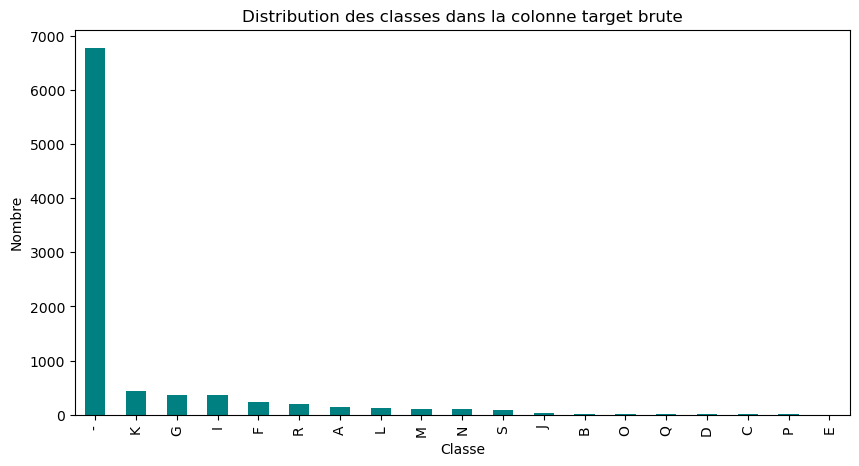

In [162]:
y=data.target

y.value_counts().plot(kind='bar', figsize=(10,5), color='teal')
plt.title("Distribution des classes dans la colonne target brute")
plt.xlabel("Classe")
plt.ylabel("Nombre")
plt.show()

On observe que les classes sont très déséquilibrées avec beaucoup d'individus sains et très peu d'individus pour les autres catégories. Je fais le choix de regrouper certaines catégories pour créer des méta-catégories : sain, hyperthyroïdie, hypothyroïdie (voir documentation du dataset kaggle). Je choisis aussi de retirer les catégories qui ne rentrent pas dans les méta-catégories car trop peu d'individus. On crée ainsi un premier set de classes, assez simple, mais déséquilibré. 

#### a. Target version 3 classes

In [163]:
data_3class = data.copy()

# On mappe les meta-catégories
diagnostics = {'-': 'negative',
             'A': 'hyperthyroid', 
             'B': 'hyperthyroid', 
             'C': 'hyperthyroid', 
             'D': 'hyperthyroid',
             'E': 'hypothyroid', 
             'F': 'hypothyroid', 
             'G': 'hypothyroid', 
             'H': 'hypothyroid'}

data_3class['target'] = data_3class['target'].map(diagnostics)

data_3class.dropna(subset=['target'], inplace=True) # On retire les individus qui ne mappent pas dans les méta-catégories

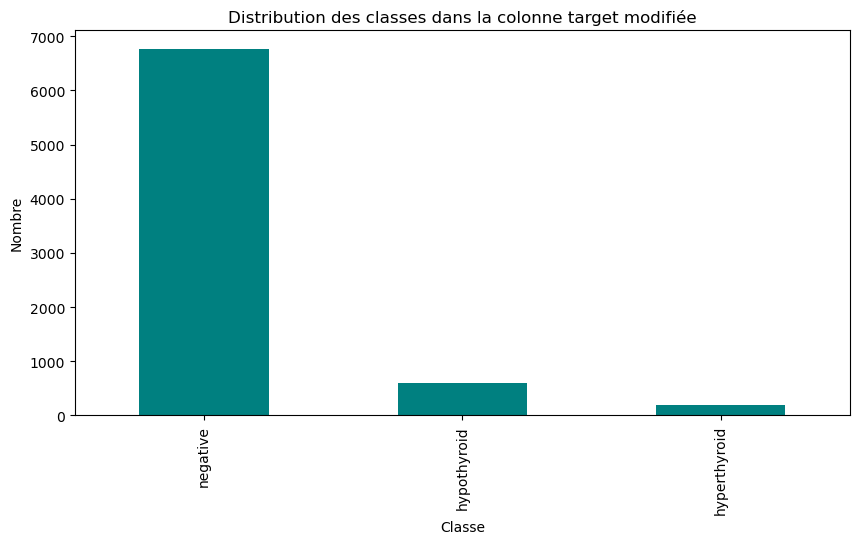

In [164]:
y=data_3class.target

y.value_counts().plot(kind='bar', figsize=(10,5), color='teal')
plt.title("Distribution des classes dans la colonne target modifiée")
plt.xlabel("Classe")
plt.ylabel("Nombre")
plt.show()

On reste dans un cas déséquilibré mais avec moins de classes et moins de bruit.

#### b. Target version 6 classes
On va aussi créer un second type de target avec 6 classes pour complexifier la prédiction. Afin d’équilibrer le réalisme clinique et la taille des classes, j'ai conservé uniquement les diagnostics présentant un effectif suffisant. Les sous-types hyperthyroïdiens ont été fusionnés, et seules deux formes d’hypothyroïdie (primaire et compensée) ont été conservées. J'ai rajouté plusieurs classes supplémentaires du jeu de données initial qui pouvaient être pertinentes, et j'ai exclu les classes post-diagnostic en lien avec le traitement. 
Ce choix aboutit à un jeu de données à six classes, équilibré et médicalement cohérent.

In [165]:
data_6class = data.copy()

# On mappe les meta-catégories
diagnostics = {'-': 'negative',
             'A': 'hyperthyroid', 
             'B': 'hyperthyroid', 
             'C': 'hyperthyroid', 
             'D': 'hyperthyroid',
             'F': 'primary hypothyroid', 
             'G': 'compensated hypothyroid', 
             'I': 'binding_protein_issue',
             'J': 'binding_protein_issue',
             'K': 'concurrent non-thyroidal illness',
             'R': 'discordant assay results'
             }

data_6class['target'] = data_6class['target'].map(diagnostics)

data_6class.dropna(subset=['target'], inplace=True) # On retire les individus qui ne mappent pas dans les méta-catégories

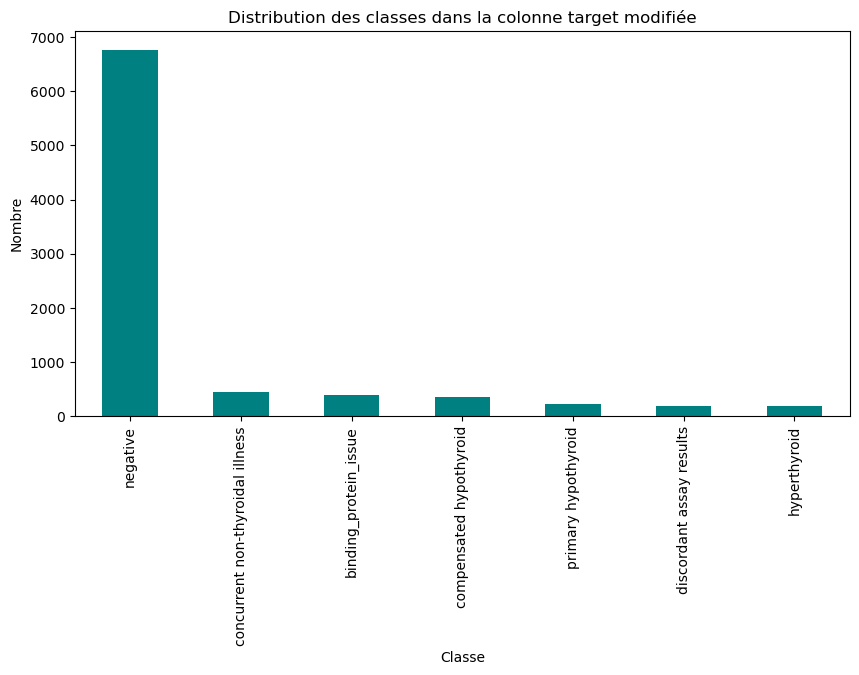

In [166]:
y=data_6class.target

y.value_counts().plot(kind='bar', figsize=(10,5), color='teal')
plt.title("Distribution des classes dans la colonne target modifiée")
plt.xlabel("Classe")
plt.ylabel("Nombre")
plt.show()

On a maintenant + de classes, avec des déséquilibres évidents et surtout des classes avec des biomarqueurs associés probablement différents.

### 2. Premier Modèle, sans Feature Engineering 

J'ai décidé de faire un premier modèle avec un Random Forest, pour avoir un point de référence et éventuellement repérer des problèmes qu'il faudra corriger par la suite.

In [167]:
data_3class.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7546 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7542 non-null   float64
 1   sex                  7296 non-null   object 
 2   on_thyroxine         7546 non-null   object 
 3   query_on_thyroxine   7546 non-null   object 
 4   on_antithyroid_meds  7546 non-null   object 
 5   sick                 7546 non-null   object 
 6   pregnant             7546 non-null   object 
 7   thyroid_surgery      7546 non-null   object 
 8   I131_treatment       7546 non-null   object 
 9   query_hypothyroid    7546 non-null   object 
 10  query_hyperthyroid   7546 non-null   object 
 11  lithium              7546 non-null   object 
 12  goitre               7546 non-null   object 
 13  tumor                7546 non-null   object 
 14  hypopituitary        7546 non-null   object 
 15  psych                7546 non-null   object

In [174]:
data_3class['TBG'].isna().mean()

np.float64(0.9656771799628943)

Je vois que la colonne TBG a presque 97% de valeurs manquantes donc pour ce premier modèle je retire la colonne. Je choisis ensuite de retirer les lignes où il y a des valeurs manquantes. 

In [175]:
data_baseline = data_3class.drop(columns=['TBG'])
data_baseline = data_baseline.dropna()

print(data_baseline.shape)

(4656, 22)


On garde 4659 individus pour le modèle baseline, ce qui est suffisant pour un premier modèle. Evidemment, si il y a une corrélation entre la variable target et les occurences de Na, on le verra plus tard et on verra comment le gérer.

#### A. Modèle baseline RandomForest brut : 

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline.drop(columns=["target"])
y=data_baseline.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

hyperthyroid       0.81      0.74      0.77        23
 hypothyroid       0.97      1.00      0.99        75
    negative       0.99      0.99      0.99       834

    accuracy                           0.99       932
   macro avg       0.93      0.91      0.92       932
weighted avg       0.99      0.99      0.99       932



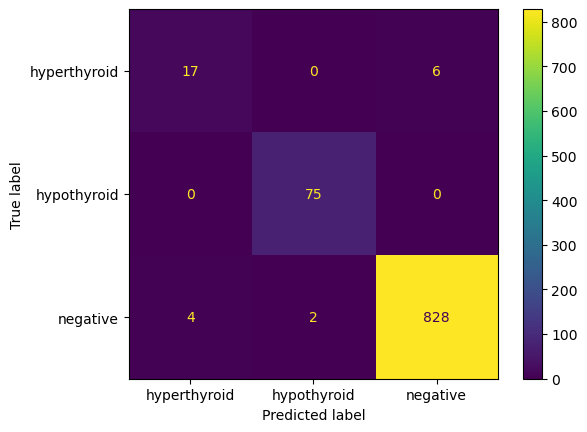

In [177]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot()

On a d'excellents résultats... Le modèle a juste un peu plus de mal à détecter l'hyperthyroïdie avec un recall à 0.74 mais le reste est quasiment parfait. C'est maintenant qu'on se questionne sur le data leakage et les variables post-diagnostic. 
=> On les retire pour voir...

#### B. Modèle baseline RandomForest sans 'leakage features' : 

In [178]:
leakage_features = [
    'on_thyroxine',
    'query_on_thyroxine',
    'on_antithyroid_meds',
    'thyroid_surgery',
    'I131_treatment',
    'query_hypothyroid',
    'query_hyperthyroid'
]

data_baseline2=data_baseline.drop(columns=leakage_features)

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline2.drop(columns=["target"])
y=data_baseline2.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

hyperthyroid       0.80      0.70      0.74        23
 hypothyroid       0.97      1.00      0.99        75
    negative       0.99      0.99      0.99       834

    accuracy                           0.99       932
   macro avg       0.92      0.90      0.91       932
weighted avg       0.99      0.99      0.99       932



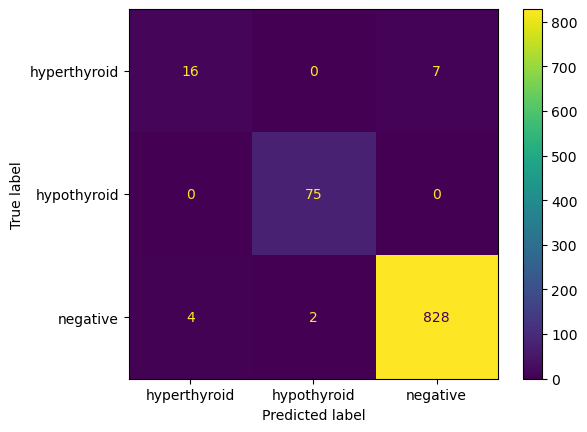

In [180]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot()

Le retrait des variables post-diagnostic ne semble pas vraiment affecter les performances du modèle, qui conserve une accuracy de 0.99.
Cela indique que les excellents résultats observés ne proviennent pas d’un effet de data leakage, mais plutôt du fort pouvoir explicatif des variables biologiques (TSH, T3, TT4, FTI…) directement liées au diagnostic médical.
On va quand même retirer les variables obtenues post-diagnostic dans la suite du projet, dans un souci de cohérence médicale.
Maintenant, essayons d'enlever les variables biologiques (taux d'hormones).

#### C. Modèle baseline RandomForest sans 'leakage features' & sans variables biologiques : 

In [181]:
variables_hormones = [
    'TSH', 'T3', 'TT4', 'T4U', 'FTI'
]

data_baseline3=data_baseline.drop(columns=variables_hormones)

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline3.drop(columns=["target"])
y=data_baseline3.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

hyperthyroid       0.17      0.09      0.11        23
 hypothyroid       0.17      0.03      0.05        75
    negative       0.90      0.98      0.93       834

    accuracy                           0.88       932
   macro avg       0.41      0.36      0.36       932
weighted avg       0.82      0.88      0.84       932



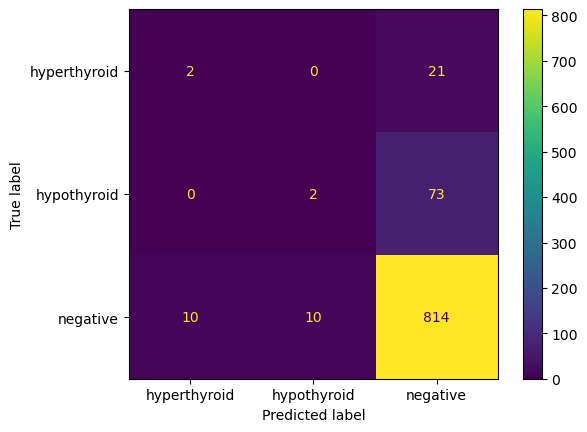

In [183]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot()

Sans les variables biologiques (TSH, T3, TT4, T4U, FTI), les performances chutent fortement : l’accuracy passe de 0.99 à 0.87, et les F1-scores pour les classes hyperthyroid et hypothyroid s’effondrent (≈0.05). Le modèle se contente de prédire la classe dominante.


**Discussion :**
Au vu des excellents résultats sur le modèle baseline, on va chercher à complexifier la prédiction en rajoutant des classes. On va maintenant tester le modèle baseline sur la subdivision en 6 classes de target.

#### D. Modèle baseline RandomForest sans 'leakage features' sur 6 classes : 

On observe des sous-classes très minoritaires. Voyons si notre baseline model est capable de les discrimier.

In [184]:
data_baseline4 = data_6class.drop(columns=['TBG'])
data_baseline4.dropna(inplace=True)

data_baseline4.drop(columns=leakage_features,axis=1,inplace=True)

print(data_baseline4.shape)

data_baseline4['target'].value_counts()


(5439, 15)


target
negative                            4165
concurrent non-thyroidal illness     406
binding_protein_issue                225
compensated hypothyroid              211
primary hypothyroid                  164
discordant assay results             152
hyperthyroid                         116
Name: count, dtype: int64

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split X,y
X=data_baseline4.drop(columns=["target"])
y=data_baseline4.target

# Split variables catégorielles / variables numériques 
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Split train test
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # on conserve la même proportion de classes avec stratify

# Preprocessing simple
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# premier modele
pipe=Pipeline([
    ('preprocess_catcol',preprocess),
    ('random_forest',RandomForestClassifier(random_state=42))
    ])

# Entraînement
pipe.fit(X_train,y_train)
y_hat=pipe.predict(X_test)

# Evaluation
print(classification_report(y_test, y_hat))

                                  precision    recall  f1-score   support

           binding_protein_issue       0.79      0.58      0.67        45
         compensated hypothyroid       0.93      0.98      0.95        42
concurrent non-thyroidal illness       0.78      0.93      0.85        81
        discordant assay results       0.78      0.81      0.79        31
                    hyperthyroid       0.76      0.83      0.79        23
                        negative       0.96      0.95      0.96       833
             primary hypothyroid       0.97      0.94      0.95        33

                        accuracy                           0.93      1088
                       macro avg       0.85      0.86      0.85      1088
                    weighted avg       0.93      0.93      0.93      1088



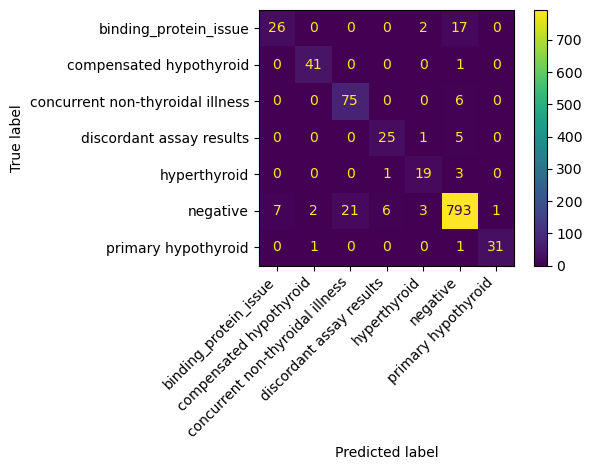

In [194]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_hat, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe.classes_)

disp.plot(cmap="viridis", values_format=".0f")  # optionnel pour une belle couleur
plt.xticks(rotation=45, ha='right')           # rotation des labels axe X
plt.yticks(rotation=0)                        # labels axe Y restent droits
plt.tight_layout()                            # évite que les labels dépassent
plt.show()

La classification en six catégories diagnostiques aboutit à d’excellentes performances, avec une accuracy de 93% et un macro-F1 de 0.85, malgré un fort déséquilibre des classes.
Le modèle parvient non seulement à distinguer les profils thyroïdiens classiques (hyperthyroïdie, hypothyroïdie primaire et compensée), mais identifie également avec une bonne précision des situations plus subtiles telles que les anomalies de protéines de liaison ou les discordances analytiques.

Ces résultats s’expliquent par le caractère hautement discriminant des marqueurs biologiques thyroïdiens (notamment TSH, T3, T4 et FTI), déjà utilisés en pratique clinique pour établir le diagnostic.
Autrement dit, le modèle reproduit efficacement le raisonnement décisionnel médical fondé sur les dosages hormonaux, ce qui justifie des performances élevées.

### 3. Analyse des Données
On va maintenant essayer d'améliorer les performances, déjà très hautes. D'abord on va regarder les corrélations entre les variables et le diagnostic.

### a. Target 3 classes

In [209]:
data_3class.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U',
       'FTI', 'TBG', 'target'],
      dtype='object')

<Axes: xlabel='target', ylabel='age'>

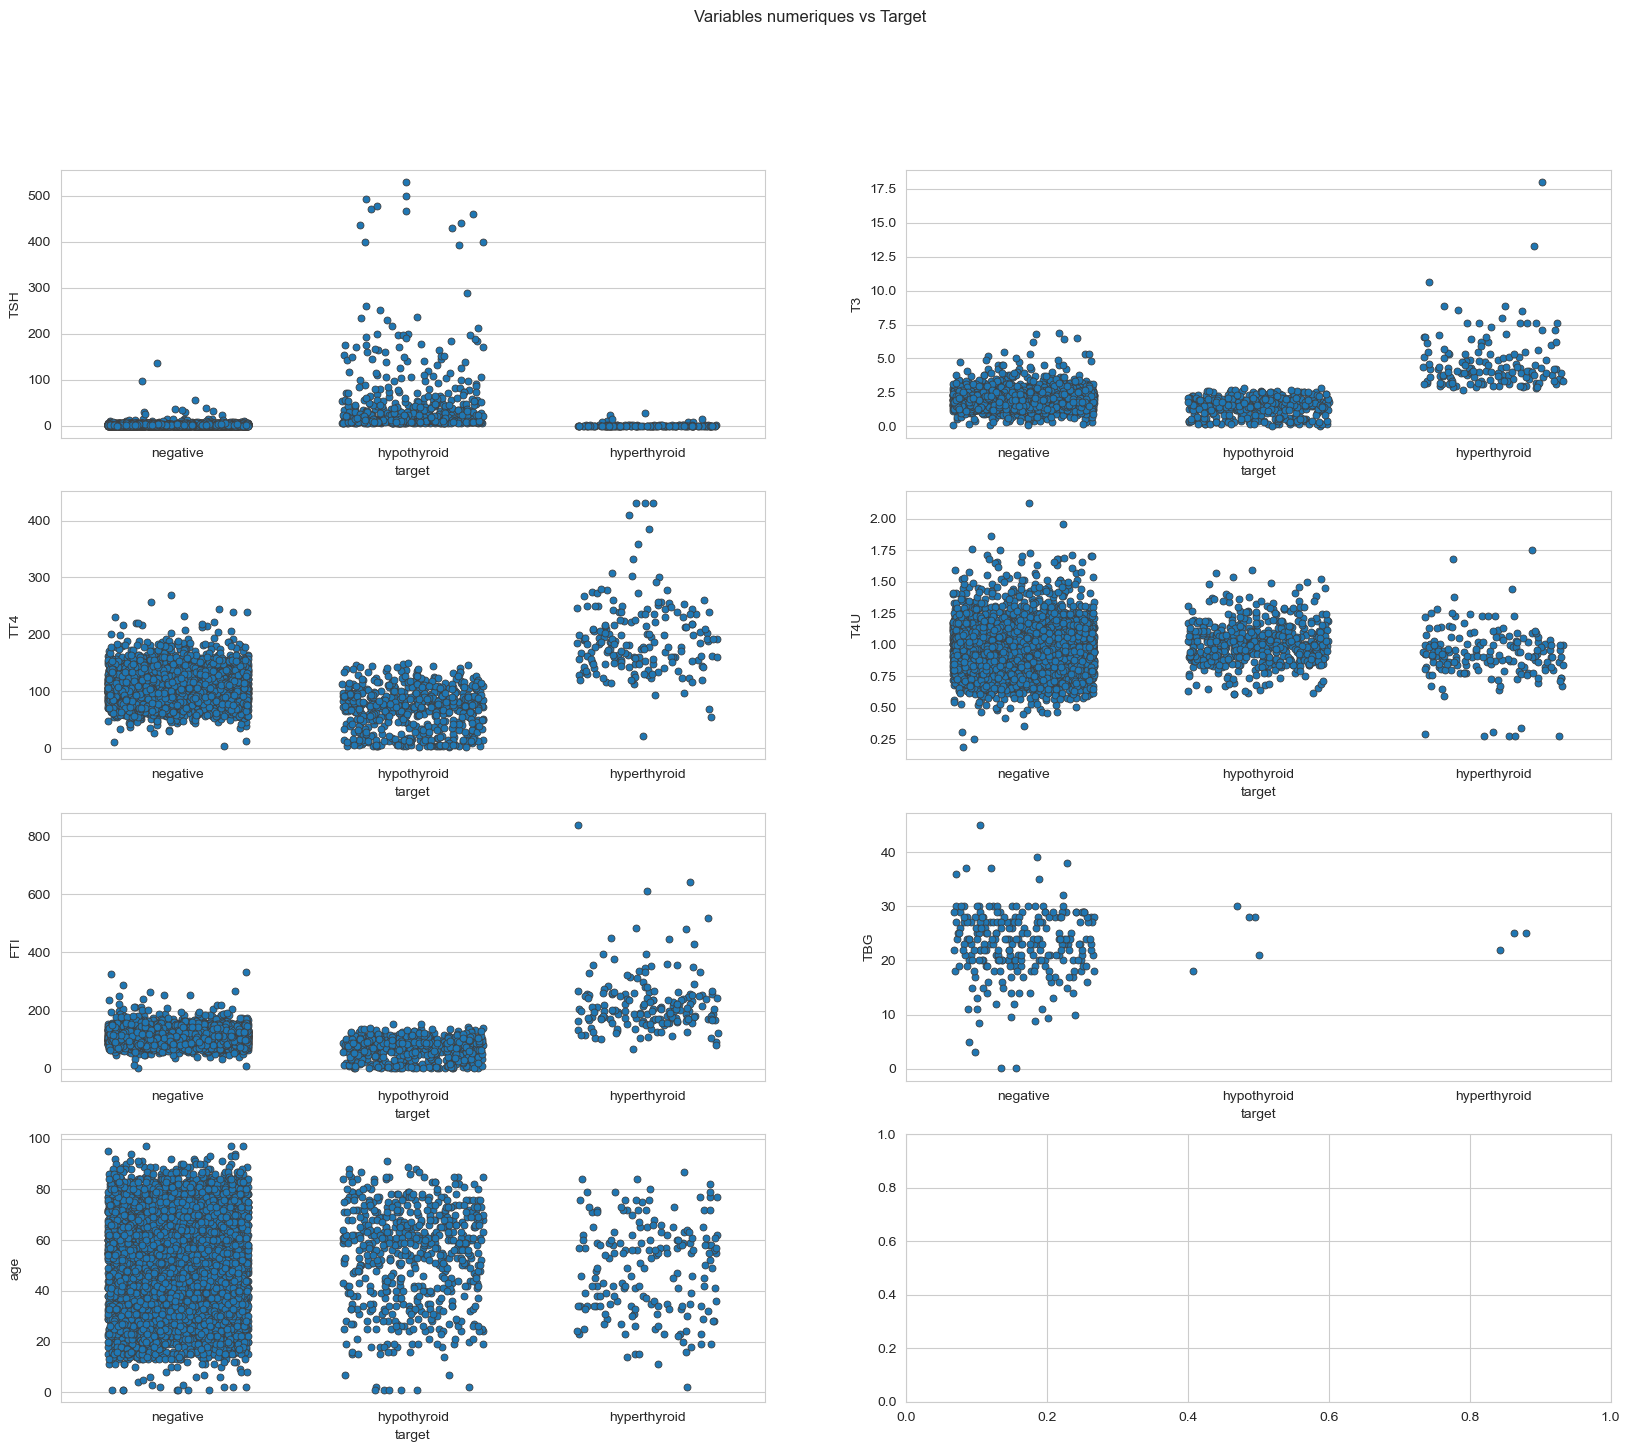

In [214]:
# plusieurs plots en grid
fig, axes = plt.subplots(4,2,figsize=(20,16))
fig.suptitle('Variables numeriques vs Target')
sns.set_style('whitegrid')

# TSH vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.TSH, linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# T3 vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.T3, linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# TT4 vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.TT4, linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
# T4U vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.T4U, linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
# FTI vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.FTI, linewidth=0.6, jitter= 0.3, ax=axes[2, 0])
# TBG vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.TBG, linewidth=0.6, jitter= 0.3, ax=axes[2, 1])
# Age vs 'target'
sns.stripplot(x=data_3class.target, y=data_3class.age, linewidth=0.6, jitter= 0.3, ax=axes[3, 0])


On observe déjà ici des relations entre le taux de certaines hormones et le diagnostic. Par contre l'âge ne semble pas discriminer la pathologie.

<Axes: >

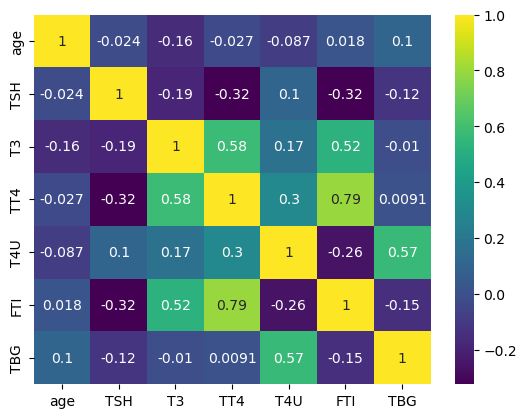

In [200]:
import seaborn as sns
num_cols = data_3class.select_dtypes(exclude='object').columns
sns.heatmap(data_3class[num_cols].corr(), annot=True, cmap="viridis")

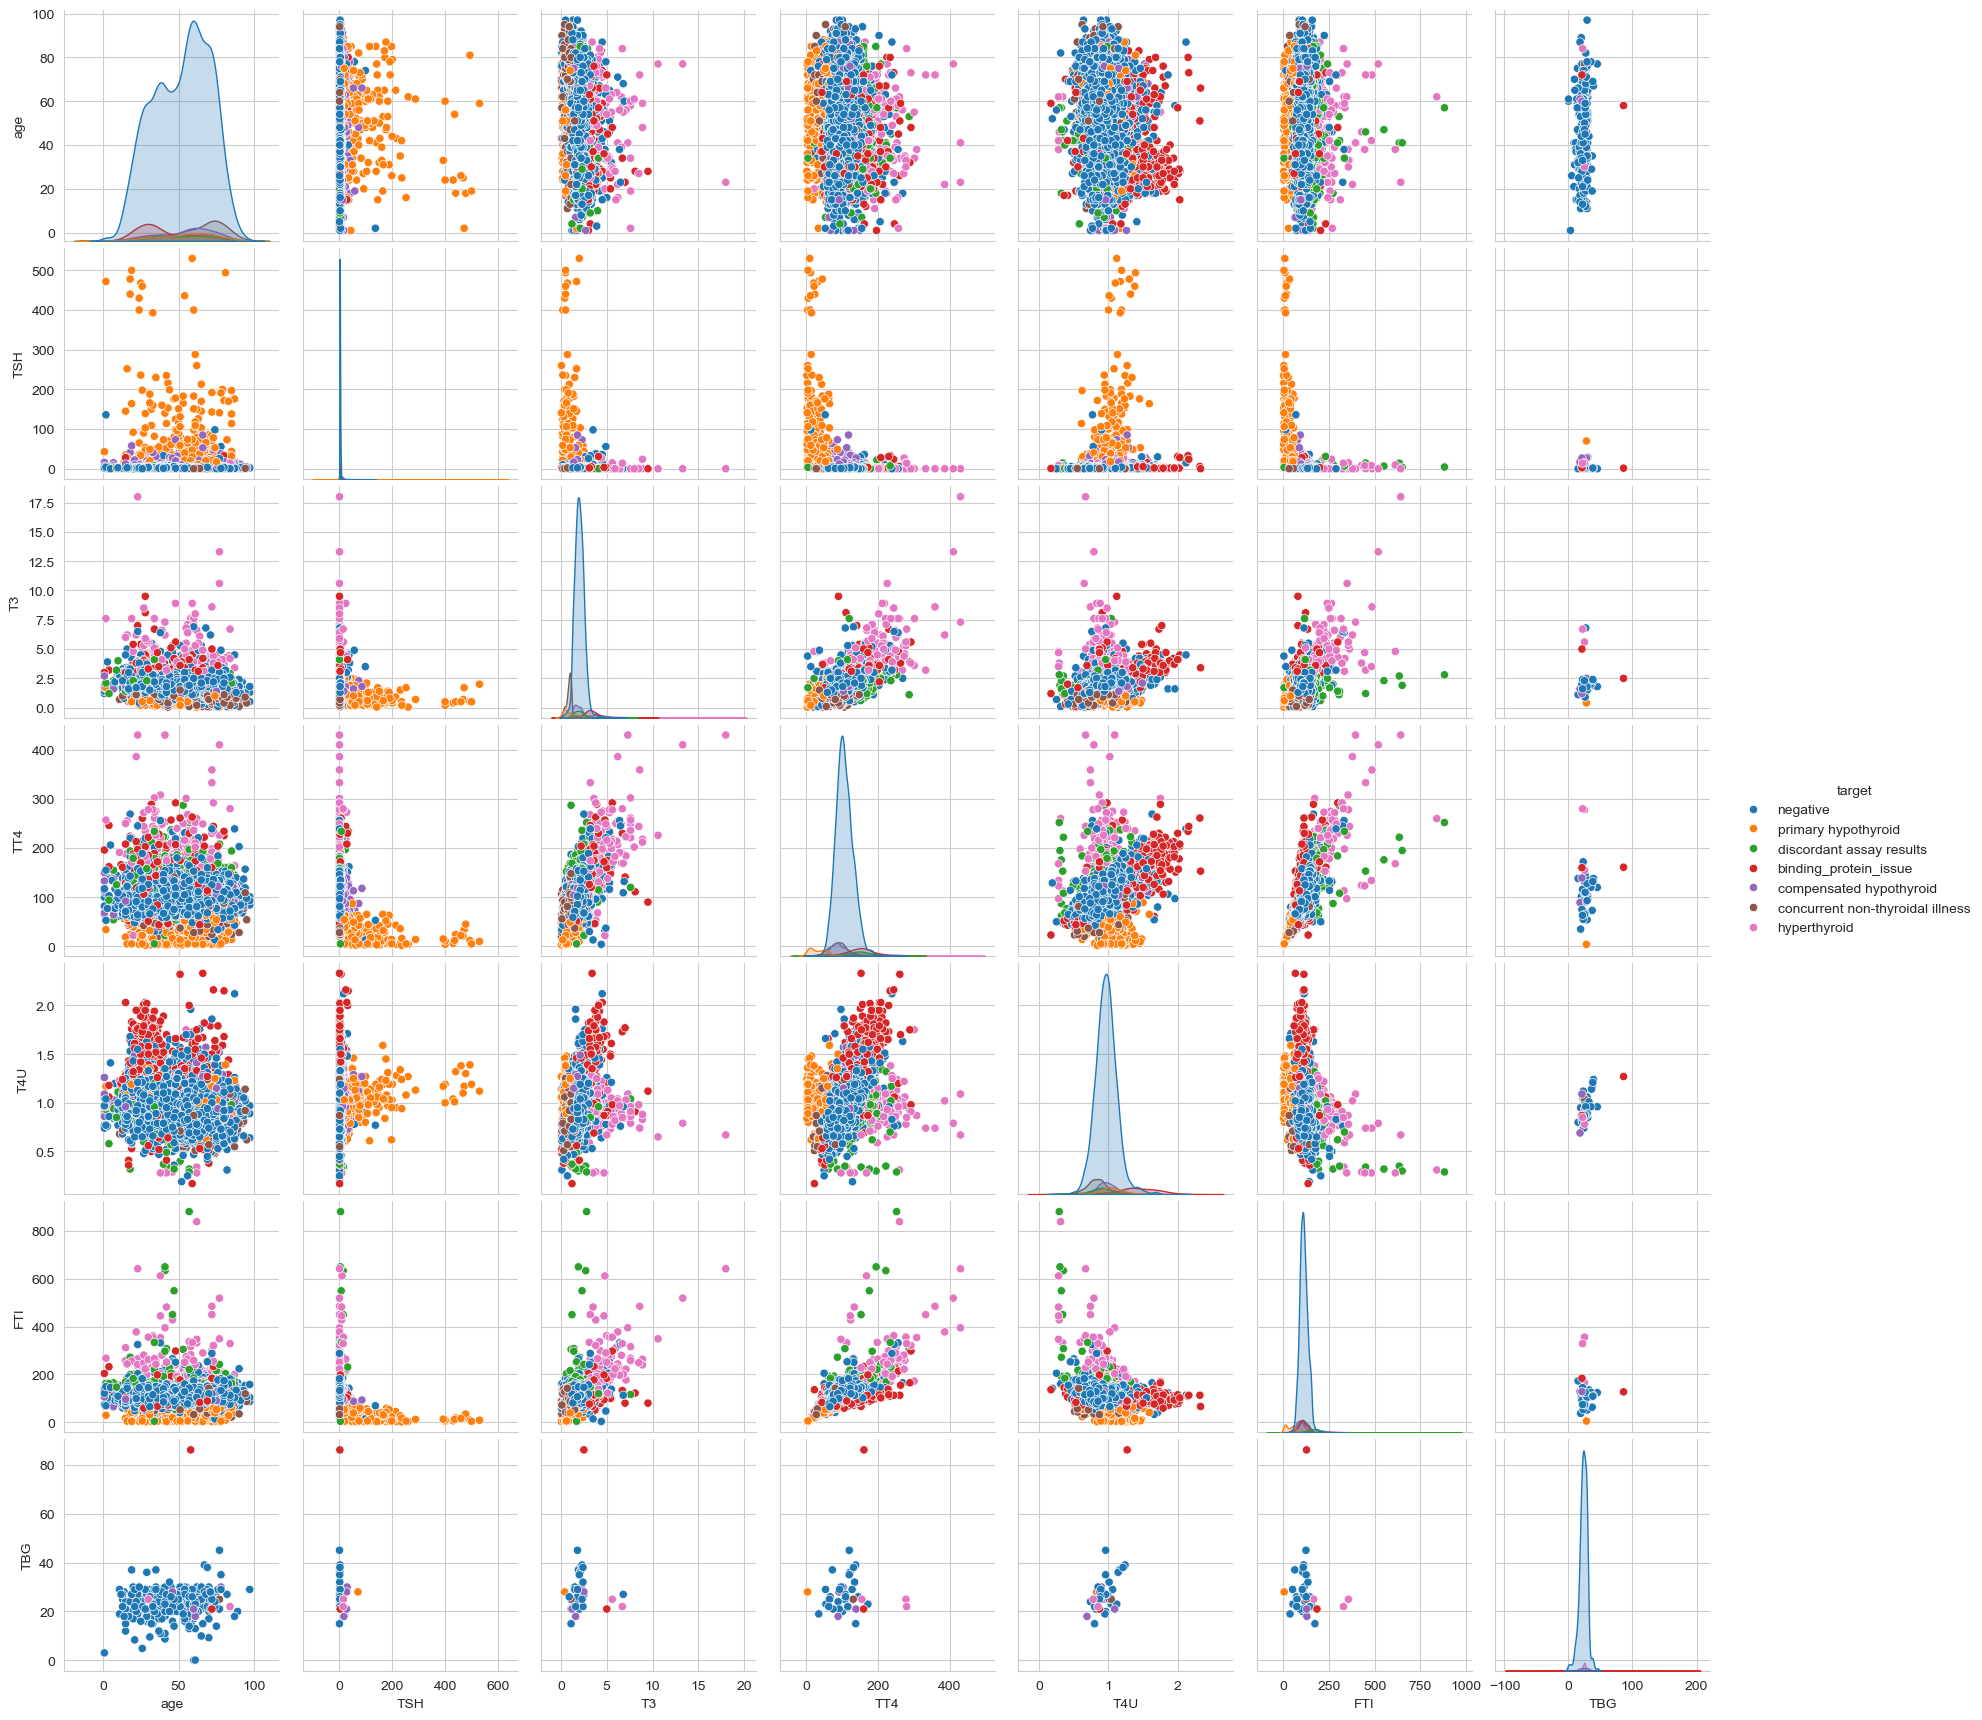

In [217]:
sns.pairplot(data_6class, vars=['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI','TBG'], hue="target")

Pas forcément l'impression que le TBG soit très discriminant, même en association avec d'autres variables. On ne le gardera probablement pas au vu des 97% de Na pour cette variable. 

### 4. Feature Engineering

### 5. Comparaison de modèles

### 6. Tuning des Hyper-Paramètres